# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/ > /dev/null # no output

    ERROR: Command errored out with exit status 1:
     command: /home/dohee/anaconda3/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-req-build-5s75ax7q/setup.py'"'"'; __file__='"'"'/tmp/pip-req-build-5s75ax7q/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-req-build-5s75ax7q/pip-egg-info
         cwd: /tmp/pip-req-build-5s75ax7q/
    Complete output (7 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-req-build-5s75ax7q/setup.py", line 25, in <module>
        exec(open('pretrainedmodels/version.py').read())
      File "/home/dohee/anaconda3/lib/python3.7/codecs.py", line 904, in open
        file = builtins.open(filename, mode, buffering)
    FileNotFoundError: [Errno 2] No such file or directory: 'pretrainedmodels/version.py'
    -----------

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/pretrainedmodels.zip
../input/bengaliaicv19feather/test_image_data_2.feather
../input/bengaliaicv19feather/train_image_data_0.feather
../input/bengaliaicv19feather/test_image_data_3.feather
../input/bengaliaicv19feather/train_image_data_2.feather
../input/bengaliaicv19feather/train_image_data_3.feather
../input/bengaliaicv19feather/test_image_data_0.feather
../input/bengaliaicv19feather/test_image_data_1.feather
../input/bengaliaicv19feather/train_image_data_1.feather
../input/pretrainedmodels/pretrainedmodels-0.7.4/setup.cfg
../input/pretrainedmodels/pretrainedmodels-0.7.4/setup.py
../input/pretrainedmodels/pretrainedmodels-0.7.4/PKG-INFO
../input/pretrainedmodels/pretrainedmodels-0.7.4/README.md
../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels.egg-info/PKG-INFO
../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels.egg-info/SOURCES.txt
../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels.egg-info/requires.txt
../input/pretrainedmodels

In [4]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [5]:
debug=False
submission=False
batch_size=32*4
device='cuda:0'
out='.'
image_size=64*2
arch='pretrained'
model_name='densenet121'

In [55]:
data = {
    "image_size": image_size,
    "threshold": 40.0,
    "arch": "pretrained",
    "model_name": model_name
}

In [56]:
with open(r'./save/args.json', 'w') as f:
    json.dump(data, f, indent=4)

In [6]:
datadir = Path('../input/bengaliai-cv19')
featherdir = Path('../input/bengaliaicv19feather')
outdir = Path('./save')

In [7]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [8]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)


image_df_list 4
CPU times: user 20.3 s, sys: 25 s, total: 45.3 s
Wall time: 9.02 s


In [10]:
os.listdir("../input/bengaliaicv19feather/")

['test_image_data_2.feather',
 'train_image_data_0.feather',
 'test_image_data_3.feather',
 'train_image_data_2.feather',
 'train_image_data_3.feather',
 'test_image_data_0.feather',
 'test_image_data_1.feather',
 'train_image_data_1.feather']

<a id="dataset"></a>
# Dataset

In [11]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [12]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        x = x.astype(np.double)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [13]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


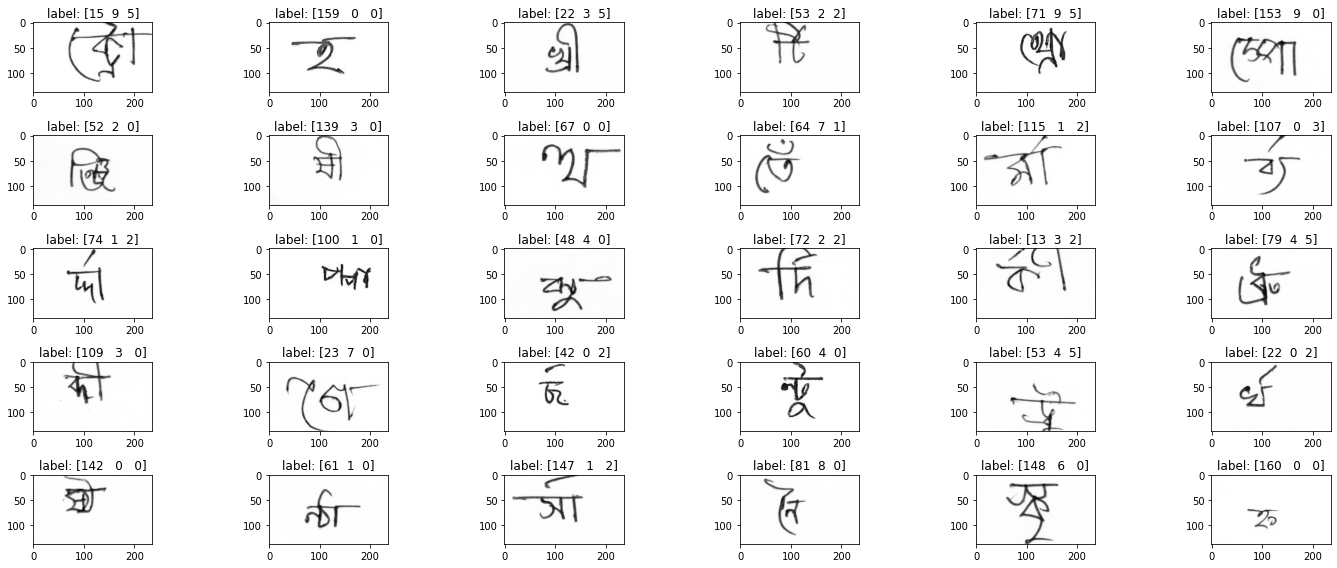

<Figure size 432x288 with 0 Axes>

In [14]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [15]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image


def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

In [16]:
# nrow, ncol = 1, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[0]
#     ax.imshow(affine_image(image), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

In [17]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[i]
#     ax.imshow(crop_char_image(image, threshold=20./255.), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

In [18]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[i]
#     ax.imshow(resize(crop_char_image(image, threshold=20./255.)), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [19]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.double)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

        if self.normalize:
            x = (x.astype(np.double) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.double)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x
        
# class Transform:
#     def __init__(self, affine=True, crop=True, size=(64, 64),
#                  normalize=True, train=True, threshold=40.,
#                  sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
#                  grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
#                  piece_affine_ratio=0., ssr_ratio=0.):
#         self.affine = affine
#         self.crop = crop
#         self.size = size
#         self.normalize = normalize
#         self.train = train
#         self.threshold = threshold / 255.
#         self.sigma = sigma / 255.

#         self.blur_ratio = blur_ratio
#         self.noise_ratio = noise_ratio
#         self.cutout_ratio = cutout_ratio
#         self.grid_distortion_ratio = grid_distortion_ratio
#         self.elastic_distortion_ratio = elastic_distortion_ratio
#         self.random_brightness_ratio = random_brightness_ratio
#         self.piece_affine_ratio = piece_affine_ratio
#         self.ssr_ratio = ssr_ratio

#     def __call__(self, example):
#         if self.train:
#             x, y = example
#         else:
#             x = example
#         # --- Augmentation ---
#         if self.affine:
#             x = affine_image(x)

#         # --- Train/Test common preprocessing ---
#         if self.crop:
#             x = crop_char_image(x, threshold=self.threshold)
#         if self.size is not None:
#             x = resize(x, size=self.size)
#         if self.sigma > 0.:
#             x = add_gaussian_noise(x, sigma=self.sigma)

#         # albumentations...
#         x = x.astype(np.float32)
#         assert x.ndim == 2
#         # 1. blur
#         if _evaluate_ratio(self.blur_ratio):
#             r = np.random.uniform()
#             if r < 0.25:
#                 x = apply_aug(A.Blur(p=1.0), x)
#             elif r < 0.5:
#                 x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
#             elif r < 0.75:
#                 x = apply_aug(A.GaussianBlur(p=1.0), x)
#             else:
#                 x = apply_aug(A.MotionBlur(p=1.0), x)

#         if _evaluate_ratio(self.noise_ratio):
#             r = np.random.uniform()
#             if r < 0.50:
#                 x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
#             else:
#                 x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

#         if _evaluate_ratio(self.cutout_ratio):
#             # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
#             x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

#         if _evaluate_ratio(self.grid_distortion_ratio):
#             x = apply_aug(A.GridDistortion(p=1.0), x)

#         if _evaluate_ratio(self.elastic_distortion_ratio):
#             x = apply_aug(A.ElasticTransform(
#                 sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

#         if _evaluate_ratio(self.random_brightness_ratio):
#             # A.RandomBrightness(p=1.0)  # Deprecated...
#             # A.RandomContrast(p=1.0)    # Deprecated...
#             x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

#         if _evaluate_ratio(self.piece_affine_ratio):
#             x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

#         if _evaluate_ratio(self.ssr_ratio):
#             x = apply_aug(A.ShiftScaleRotate(
#                 shift_limit=0.0625,
#                 scale_limit=0.1,
#                 rotate_limit=30,
#                 p=1.0), x)

#         if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051
#         if x.ndim == 2:
#             x = x[None, :, :]
#         x = x.astype(np.float32)
#         if self.train:
#             y = y.astype(np.int64)
#             return x, y
#         else:
#             return x
        

In [20]:
train_transform = Transform(
    size=(image_size, image_size), threshold=20.,
    sigma=-1., blur_ratio=0.2, noise_ratio=0.2, cutout_ratio=0.2,
    grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
    piece_affine_ratio=0.2, ssr_ratio=0.2)
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

In [21]:
# nrow, ncol = 1, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[0]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

In [22]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[i]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [23]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [24]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [25]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [26]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [27]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='densenet121',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
        h = self.conv0(x)
        h = self.base_model.features(h)
        
        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
            
        return h

## Classifier

In [28]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.9997:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
    
#     print(lam)
#     print(data.shape)
#     print(indices)
#     print(bbx1, bbx2, bby1, bby2)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [29]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(6)
        
        if const<2:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data

        elif const<4:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data

            
            
        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        if const<4:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = loss_grapheme + loss_vowel + loss_consonant  
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = loss_grapheme + loss_vowel + loss_consonant
            
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    
    
    
    def forward_val(self, x, y=None):

        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                
                
                
                pred = self.predictor(batch)
                
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

In [30]:
# import torch
# from torch import nn
# import torch.nn.functional as F
# from tqdm import tqdm


# def accuracy(y, t):
#     pred_label = torch.argmax(y, dim=1)
#     count = pred_label.shape[0]
#     correct = (pred_label == t).sum().type(torch.double)
#     acc = correct / count
#     return acc


# class BengaliClassifier(nn.Module):
#     def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
#         super(BengaliClassifier, self).__init__()
#         self.n_grapheme = n_grapheme
#         self.n_vowel = n_vowel
#         self.n_consonant = n_consonant
#         self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
#         self.predictor = predictor.float()
        
#         self.metrics_keys = [
#             'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
#             'acc_grapheme', 'acc_vowel', 'acc_consonant']

#     def forward(self, x, y=None):
#         const = np.random.rand()
#         if const<0.4:        
#             # mixup
#             data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#             x = data
#         elif const<0.8:
#             # cutmix
#             data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
#             x = data
#         pred = self.predictor(x)
        
        
#         if isinstance(pred, tuple):
#             assert len(pred) == 3
#             preds = pred
#         else:
#             assert pred.shape[1] == self.n_total_class
#             preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
#         if const<0.8:
#             # cutmix or mixup
#             targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
#             preds1, preds2, preds3 = preds[0], preds[1], preds[2]
#             #loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
#             #loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
#             #loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            
            
#             #criterion = nn.CrossEntropyLoss()
#             #loss_grapheme = lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) 
#             #loss_vowel = lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4)
#             #loss_consonant = lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)
            
            
#             loss = loss_grapheme + loss_vowel + loss_consonant  
            
            
            
            
#         else:
#             loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
#             loss_vowel = F.cross_entropy(preds[1], y[:, 1])
#             loss_consonant = F.cross_entropy(preds[2], y[:, 2])
#             loss = loss_grapheme + loss_vowel + loss_consonant
            
#         metrics = {
#             'loss': loss.item(),
#             'loss_grapheme': loss_grapheme.item(),
#             'loss_vowel': loss_vowel.item(),
#             'loss_consonant': loss_consonant.item(),
#             'acc_grapheme': accuracy(preds[0], y[:, 0]),
#             'acc_vowel': accuracy(preds[1], y[:, 1]),
#             'acc_consonant': accuracy(preds[2], y[:, 2]),
#         }
        
#         return loss, metrics, pred
    
    
    
#     def forward_val(self, x, y=None):

#         pred = self.predictor(x)
        
#         if isinstance(pred, tuple):
#             assert len(pred) == 3
#             preds = pred
#         else:
#             assert pred.shape[1] == self.n_total_class
#             preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
#         loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
#         loss_vowel = F.cross_entropy(preds[1], y[:, 1])
#         loss_consonant = F.cross_entropy(preds[2], y[:, 2])
#         loss = loss_grapheme + loss_vowel + loss_consonant
#         metrics = {
#             'loss': loss.item(),
#             'loss_grapheme': loss_grapheme.item(),
#             'loss_vowel': loss_vowel.item(),
#             'loss_consonant': loss_consonant.item(),
#             'acc_grapheme': accuracy(preds[0], y[:, 0]),
#             'acc_vowel': accuracy(preds[1], y[:, 1]),
#             'acc_consonant': accuracy(preds[2], y[:, 2]),
#         }
        
#         return loss, metrics, pred
    

#     def calc(self, data_loader):
#         device: torch.device = next(self.parameters()).device
#         self.eval()
#         output_list = []
#         with torch.no_grad():
#             for batch in tqdm(data_loader):
#                 # TODO: support general preprocessing.
#                 # If `data` is not `Data` instance, `to` method is not supported!
#                 batch = batch.to(device)
                
                
                
#                 pred = self.predictor(batch)
                
                
#                 output_list.append(pred)
#         output = torch.cat(output_list, dim=0)
#         preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
#         return preds

#     def predict_proba(self, data_loader):
#         preds = self.calc(data_loader)
#         return [F.softmax(p, dim=1) for p in preds]

#     def predict(self, data_loader):
#         preds = self.calc(data_loader)
#         pred_labels = [torch.argmax(p, dim=1) for p in preds]
#         return pred_labels


<a id="train"></a>
# Training code

## prepare data

In [31]:
n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.9)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

perm = np.random.RandomState(777).permutation(n_dataset)
print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
print('predictor', type(predictor))

classifier = BengaliClassifier(predictor).to(device)


perm [ 95762  34576  11800 ... 183206 113455  63591]
train_dataset 180756 valid_dataset 20084
n_total 186
predictor <class '__main__.PretrainedCNN'>


/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning:

nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.



In [32]:
predictor

PretrainedCNN(
  (conv0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _D

## Ignite utility

pytorch-ignite utility class for training

In [33]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        
#         # mixup
#         data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#         #print(data.shape)
#         print(len(targets))
#         print(targets[0].shape)
#         print(y.shape)
        
#         print(targets)
#         print(y)

        
        loss, metrics, pred_y = classifier(x, y)
        
#         print(pred_y.shape)
#         print(pred_y)
#         print("---------------")
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'./save/model_{count:06}.pt',
                 interval=10, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            # self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [34]:
# def create_trainer(classifier, optimizer, device):
#     classifier.to(device)    
#     def update_fn(engine, batch):
#         classifier.train()
#         optimizer.zero_grad()

#         # batch = [elem.to(device) for elem in batch]
#         x, y = [elem.to(device) for elem in batch]        
#         x = x.float()
        
#         print(x.shape)
#         print(y.shape)
        
#         loss, metrics, pred_y = classifier(x, y)

In [35]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))

/home/dohee/anaconda3/envs/Bengali/lib/python3.6/site-packages/ignite/contrib/handlers/tqdm_logger.py:97: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [36]:
trainer.run(train_loader, max_epochs=100)

/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



epoch      1 train/loss  4.671670 train/loss_grapheme  2.638109 train/loss_vowel  1.069856 train/loss_consonant  0.963705 train/acc_grapheme  0.423545 train/acc_vowel  0.672610 train/acc_consonant  0.748634 train/recall  0.523956 valid/loss  1.262134 valid/loss_grapheme  0.644731 valid/loss_vowel  0.280731 valid/loss_consonant  0.336672 valid/acc_grapheme  0.867956 valid/acc_vowel  0.960021 valid/acc_consonant  0.960220 valid/recall  0.921312 lr  0.001000 elapsed_time  650.959550 


epoch      2 train/loss  2.926775 train/loss_grapheme  1.649959 train/loss_vowel  0.744014 train/loss_consonant  0.532802 train/acc_grapheme  0.585168 train/acc_vowel  0.730148 train/acc_consonant  0.815468 train/recall  0.661643 valid/loss  0.934378 valid/loss_grapheme  0.484053 valid/loss_vowel  0.232408 valid/loss_consonant  0.217917 valid/acc_grapheme  0.897425 valid/acc_vowel  0.967491 valid/acc_consonant  0.962460 valid/recall  0.927836 lr  0.001000 elapsed_time  1298.014252 


epoch      3 train/loss  2.655113 train/loss_grapheme  1.511975 train/loss_vowel  0.686645 train/loss_consonant  0.456494 train/acc_grapheme  0.587860 train/acc_vowel  0.721280 train/acc_consonant  0.809867 train/recall  0.663019 valid/loss  0.746944 valid/loss_grapheme  0.399016 valid/loss_vowel  0.184279 valid/loss_consonant  0.163649 valid/acc_grapheme  0.921103 valid/acc_vowel  0.975353 valid/acc_consonant  0.973014 valid/recall  0.945798 lr  0.001000 elapsed_time  1939.977439 


epoch      4 train/loss  2.424898 train/loss_grapheme  1.388454 train/loss_vowel  0.626581 train/loss_consonant  0.409863 train/acc_grapheme  0.601391 train/acc_vowel  0.725770 train/acc_consonant  0.814242 train/recall  0.673172 valid/loss  0.694124 valid/loss_grapheme  0.340046 valid/loss_vowel  0.198559 valid/loss_consonant  0.155519 valid/acc_grapheme  0.931050 valid/acc_vowel  0.979443 valid/acc_consonant  0.976641 valid/recall  0.951494 lr  0.001000 elapsed_time  2582.197956 


epoch      5 train/loss  2.243293 train/loss_grapheme  1.288030 train/loss_vowel  0.579210 train/loss_consonant  0.376053 train/acc_grapheme  0.610275 train/acc_vowel  0.727484 train/acc_consonant  0.817106 train/recall  0.677910 valid/loss  0.572116 valid/loss_grapheme  0.307053 valid/loss_vowel  0.140694 valid/loss_consonant  0.124369 valid/acc_grapheme  0.934538 valid/acc_vowel  0.979975 valid/acc_consonant  0.977946 valid/recall  0.951515 lr  0.001000 elapsed_time  3223.222588 


epoch      6 train/loss  2.188041 train/loss_grapheme  1.252025 train/loss_vowel  0.566055 train/loss_consonant  0.369961 train/acc_grapheme  0.620498 train/acc_vowel  0.732598 train/acc_consonant  0.817249 train/recall  0.686250 valid/loss  0.482187 valid/loss_grapheme  0.286841 valid/loss_vowel  0.102381 valid/loss_consonant  0.092964 valid/acc_grapheme  0.929288 valid/acc_vowel  0.982966 valid/acc_consonant  0.981782 valid/recall  0.947820 lr  0.001000 elapsed_time  3864.719816 


epoch      7 train/loss  2.046102 train/loss_grapheme  1.165719 train/loss_vowel  0.532942 train/loss_consonant  0.347441 train/acc_grapheme  0.642720 train/acc_vowel  0.744751 train/acc_consonant  0.824195 train/recall  0.701229 valid/loss  0.406848 valid/loss_grapheme  0.219782 valid/loss_vowel  0.097011 valid/loss_consonant  0.090055 valid/acc_grapheme  0.949223 valid/acc_vowel  0.986515 valid/acc_consonant  0.983673 valid/recall  0.964613 lr  0.001000 elapsed_time  4508.589171 


epoch      8 train/loss  1.985176 train/loss_grapheme  1.133723 train/loss_vowel  0.515968 train/loss_consonant  0.335484 train/acc_grapheme  0.643347 train/acc_vowel  0.745298 train/acc_consonant  0.829481 train/recall  0.703822 valid/loss  0.462735 valid/loss_grapheme  0.235115 valid/loss_vowel  0.127177 valid/loss_consonant  0.100442 valid/acc_grapheme  0.946546 valid/acc_vowel  0.985470 valid/acc_consonant  0.985420 valid/recall  0.962649 lr  0.001000 elapsed_time  5151.531574 


epoch      9 train/loss  2.035300 train/loss_grapheme  1.158127 train/loss_vowel  0.530247 train/loss_consonant  0.346926 train/acc_grapheme  0.638670 train/acc_vowel  0.742640 train/acc_consonant  0.826655 train/recall  0.699102 valid/loss  0.538897 valid/loss_grapheme  0.265293 valid/loss_vowel  0.153436 valid/loss_consonant  0.120168 valid/acc_grapheme  0.951473 valid/acc_vowel  0.986510 valid/acc_consonant  0.985166 valid/recall  0.968542 lr  0.001000 elapsed_time  5793.384992 


epoch     10 train/loss  1.911335 train/loss_grapheme  1.083845 train/loss_vowel  0.500265 train/loss_consonant  0.327225 train/acc_grapheme  0.641692 train/acc_vowel  0.739802 train/acc_consonant  0.823466 train/recall  0.696783 valid/loss  0.449071 valid/loss_grapheme  0.246180 valid/loss_vowel  0.112313 valid/loss_consonant  0.090579 valid/acc_grapheme  0.949925 valid/acc_vowel  0.986012 valid/acc_consonant  0.985310 valid/recall  0.965161 lr  0.001000 elapsed_time  6435.973784 


epoch     11 train/loss  1.876971 train/loss_grapheme  1.060710 train/loss_vowel  0.493614 train/loss_consonant  0.322648 train/acc_grapheme  0.666505 train/acc_vowel  0.761117 train/acc_consonant  0.837147 train/recall  0.722069 valid/loss  0.343433 valid/loss_grapheme  0.195133 valid/loss_vowel  0.077467 valid/loss_consonant  0.070833 valid/acc_grapheme  0.950810 valid/acc_vowel  0.987062 valid/acc_consonant  0.985315 valid/recall  0.964731 lr  0.001000 elapsed_time  7078.522529 


epoch     12 train/loss  1.829586 train/loss_grapheme  1.032908 train/loss_vowel  0.481109 train/loss_consonant  0.315570 train/acc_grapheme  0.665634 train/acc_vowel  0.756530 train/acc_consonant  0.836447 train/recall  0.719843 valid/loss  0.422136 valid/loss_grapheme  0.222618 valid/loss_vowel  0.107890 valid/loss_consonant  0.091628 valid/acc_grapheme  0.950084 valid/acc_vowel  0.987306 valid/acc_consonant  0.985813 valid/recall  0.964503 lr  0.001000 elapsed_time  7720.847232 


epoch     13 train/loss  1.813646 train/loss_grapheme  1.020994 train/loss_vowel  0.479317 train/loss_consonant  0.313335 train/acc_grapheme  0.669093 train/acc_vowel  0.758078 train/acc_consonant  0.836193 train/recall  0.720005 valid/loss  0.290556 valid/loss_grapheme  0.168089 valid/loss_vowel  0.061410 valid/loss_consonant  0.061057 valid/acc_grapheme  0.955249 valid/acc_vowel  0.987460 valid/acc_consonant  0.986062 valid/recall  0.965669 lr  0.001000 elapsed_time  8361.490632 


epoch     14 train/loss  1.820120 train/loss_grapheme  1.025022 train/loss_vowel  0.480275 train/loss_consonant  0.314824 train/acc_grapheme  0.670415 train/acc_vowel  0.762319 train/acc_consonant  0.839028 train/recall  0.723672 valid/loss  0.344239 valid/loss_grapheme  0.186665 valid/loss_vowel  0.082947 valid/loss_consonant  0.074627 valid/acc_grapheme  0.954807 valid/acc_vowel  0.988401 valid/acc_consonant  0.987410 valid/recall  0.968753 lr  0.001000 elapsed_time  9003.426706 


epoch     15 train/loss  1.837541 train/loss_grapheme  1.032161 train/loss_vowel  0.486494 train/loss_consonant  0.318886 train/acc_grapheme  0.656383 train/acc_vowel  0.750265 train/acc_consonant  0.829383 train/recall  0.710768 valid/loss  0.342226 valid/loss_grapheme  0.184667 valid/loss_vowel  0.085417 valid/loss_consonant  0.072142 valid/acc_grapheme  0.957981 valid/acc_vowel  0.988704 valid/acc_consonant  0.986465 valid/recall  0.967837 lr  0.001000 elapsed_time  9644.969633 


epoch     16 train/loss  1.766592 train/loss_grapheme  0.990244 train/loss_vowel  0.467914 train/loss_consonant  0.308434 train/acc_grapheme  0.660651 train/acc_vowel  0.752439 train/acc_consonant  0.832421 train/recall  0.711086 valid/loss  0.382802 valid/loss_grapheme  0.200180 valid/loss_vowel  0.100568 valid/loss_consonant  0.082054 valid/acc_grapheme  0.956399 valid/acc_vowel  0.989445 valid/acc_consonant  0.986908 valid/recall  0.969141 lr  0.001000 elapsed_time  10286.250602 


epoch     17 train/loss  1.805902 train/loss_grapheme  1.012772 train/loss_vowel  0.478591 train/loss_consonant  0.314539 train/acc_grapheme  0.679605 train/acc_vowel  0.771188 train/acc_consonant  0.842559 train/recall  0.731646 valid/loss  0.309390 valid/loss_grapheme  0.173799 valid/loss_vowel  0.071905 valid/loss_consonant  0.063687 valid/acc_grapheme  0.956897 valid/acc_vowel  0.989351 valid/acc_consonant  0.987405 valid/recall  0.968354 lr  0.001000 elapsed_time  10927.751860 


epoch     18 train/loss  1.775317 train/loss_grapheme  0.991862 train/loss_vowel  0.473493 train/loss_consonant  0.309963 train/acc_grapheme  0.672628 train/acc_vowel  0.761557 train/acc_consonant  0.837810 train/recall  0.721876 valid/loss  0.359138 valid/loss_grapheme  0.190418 valid/loss_vowel  0.090247 valid/loss_consonant  0.078473 valid/acc_grapheme  0.957384 valid/acc_vowel  0.989102 valid/acc_consonant  0.987062 valid/recall  0.968751 lr  0.001000 elapsed_time  11569.409298 


epoch     19 train/loss  1.711653 train/loss_grapheme  0.954743 train/loss_vowel  0.456261 train/loss_consonant  0.300649 train/acc_grapheme  0.686326 train/acc_vowel  0.772812 train/acc_consonant  0.845146 train/recall  0.734786 valid/loss  0.329940 valid/loss_grapheme  0.175248 valid/loss_vowel  0.082549 valid/loss_consonant  0.072143 valid/acc_grapheme  0.955985 valid/acc_vowel  0.988799 valid/acc_consonant  0.988057 valid/recall  0.970633 lr  0.001000 elapsed_time  12210.656016 


epoch     20 train/loss  1.686913 train/loss_grapheme  0.937919 train/loss_vowel  0.451487 train/loss_consonant  0.297507 train/acc_grapheme  0.657334 train/acc_vowel  0.746658 train/acc_consonant  0.829571 train/recall  0.706063 valid/loss  0.365874 valid/loss_grapheme  0.189703 valid/loss_vowel  0.099525 valid/loss_consonant  0.076646 valid/acc_grapheme  0.958494 valid/acc_vowel  0.988455 valid/acc_consonant  0.986714 valid/recall  0.970389 lr  0.001000 elapsed_time  12850.884833 


epoch     21 train/loss  1.704702 train/loss_grapheme  0.946612 train/loss_vowel  0.458466 train/loss_consonant  0.299623 train/acc_grapheme  0.665894 train/acc_vowel  0.752523 train/acc_consonant  0.832658 train/recall  0.714292 valid/loss  0.336906 valid/loss_grapheme  0.172871 valid/loss_vowel  0.092999 valid/loss_consonant  0.071037 valid/acc_grapheme  0.958987 valid/acc_vowel  0.989749 valid/acc_consonant  0.988008 valid/recall  0.970656 lr  0.001000 elapsed_time  13492.300214 


epoch     22 train/loss  1.718892 train/loss_grapheme  0.954265 train/loss_vowel  0.460467 train/loss_consonant  0.304159 train/acc_grapheme  0.670593 train/acc_vowel  0.761572 train/acc_consonant  0.837052 train/recall  0.721613 valid/loss  0.329190 valid/loss_grapheme  0.176791 valid/loss_vowel  0.084462 valid/loss_consonant  0.067937 valid/acc_grapheme  0.959280 valid/acc_vowel  0.988401 valid/acc_consonant  0.987609 valid/recall  0.970340 lr  0.001000 elapsed_time  14131.730977 


epoch     23 train/loss  1.680178 train/loss_grapheme  0.931290 train/loss_vowel  0.451206 train/loss_consonant  0.297682 train/acc_grapheme  0.681092 train/acc_vowel  0.767991 train/acc_consonant  0.842301 train/recall  0.728478 valid/loss  0.331574 valid/loss_grapheme  0.175962 valid/loss_vowel  0.085953 valid/loss_consonant  0.069659 valid/acc_grapheme  0.960838 valid/acc_vowel  0.989202 valid/acc_consonant  0.988704 valid/recall  0.972710 lr  0.001000 elapsed_time  14772.851094 


epoch     24 train/loss  1.596842 train/loss_grapheme  0.883788 train/loss_vowel  0.428681 train/loss_consonant  0.284373 train/acc_grapheme  0.677299 train/acc_vowel  0.761952 train/acc_consonant  0.838813 train/recall  0.724150 valid/loss  0.248081 valid/loss_grapheme  0.147872 valid/loss_vowel  0.049015 valid/loss_consonant  0.051194 valid/acc_grapheme  0.962132 valid/acc_vowel  0.990446 valid/acc_consonant  0.988754 valid/recall  0.972867 lr  0.001000 elapsed_time  15413.585591 


epoch     25 train/loss  1.657433 train/loss_grapheme  0.918768 train/loss_vowel  0.445537 train/loss_consonant  0.293127 train/acc_grapheme  0.670285 train/acc_vowel  0.758836 train/acc_consonant  0.835868 train/recall  0.720250 valid/loss  0.279646 valid/loss_grapheme  0.155461 valid/loss_vowel  0.064552 valid/loss_consonant  0.059633 valid/acc_grapheme  0.961485 valid/acc_vowel  0.990545 valid/acc_consonant  0.988152 valid/recall  0.971800 lr  0.001000 elapsed_time  16053.362128 


epoch     26 train/loss  1.637715 train/loss_grapheme  0.904361 train/loss_vowel  0.441458 train/loss_consonant  0.291896 train/acc_grapheme  0.670002 train/acc_vowel  0.756221 train/acc_consonant  0.834743 train/recall  0.718619 valid/loss  0.291183 valid/loss_grapheme  0.160636 valid/loss_vowel  0.067990 valid/loss_consonant  0.062557 valid/acc_grapheme  0.961082 valid/acc_vowel  0.989451 valid/acc_consonant  0.988953 valid/recall  0.972205 lr  0.001000 elapsed_time  16694.296290 


epoch     27 train/loss  1.682934 train/loss_grapheme  0.926432 train/loss_vowel  0.454728 train/loss_consonant  0.301774 train/acc_grapheme  0.658929 train/acc_vowel  0.746923 train/acc_consonant  0.826734 train/recall  0.708682 valid/loss  0.284144 valid/loss_grapheme  0.155687 valid/loss_vowel  0.068486 valid/loss_consonant  0.059971 valid/acc_grapheme  0.962032 valid/acc_vowel  0.989451 valid/acc_consonant  0.988455 valid/recall  0.971106 lr  0.001000 elapsed_time  17335.161432 


epoch     28 train/loss  1.633558 train/loss_grapheme  0.902325 train/loss_vowel  0.440984 train/loss_consonant  0.290249 train/acc_grapheme  0.671706 train/acc_vowel  0.761236 train/acc_consonant  0.839084 train/recall  0.721661 valid/loss  0.301820 valid/loss_grapheme  0.162529 valid/loss_vowel  0.073988 valid/loss_consonant  0.065302 valid/acc_grapheme  0.962231 valid/acc_vowel  0.989600 valid/acc_consonant  0.989351 valid/recall  0.973217 lr  0.001000 elapsed_time  17975.529928 


epoch     29 train/loss  1.577669 train/loss_grapheme  0.867241 train/loss_vowel  0.427170 train/loss_consonant  0.283257 train/acc_grapheme  0.677589 train/acc_vowel  0.761939 train/acc_consonant  0.838135 train/recall  0.726192 valid/loss  0.303541 valid/loss_grapheme  0.164353 valid/loss_vowel  0.074940 valid/loss_consonant  0.064247 valid/acc_grapheme  0.962923 valid/acc_vowel  0.990396 valid/acc_consonant  0.989053 valid/recall  0.973772 lr  0.001000 elapsed_time  18616.212184 


epoch     30 train/loss  1.564473 train/loss_grapheme  0.859198 train/loss_vowel  0.423497 train/loss_consonant  0.281778 train/acc_grapheme  0.681091 train/acc_vowel  0.764079 train/acc_consonant  0.838566 train/recall  0.724367 valid/loss  0.278377 valid/loss_grapheme  0.156775 valid/loss_vowel  0.065618 valid/loss_consonant  0.055984 valid/acc_grapheme  0.961833 valid/acc_vowel  0.989948 valid/acc_consonant  0.989252 valid/recall  0.971753 lr  0.001000 elapsed_time  19256.472167 


epoch     31 train/loss  1.691659 train/loss_grapheme  0.929472 train/loss_vowel  0.459395 train/loss_consonant  0.302791 train/acc_grapheme  0.675242 train/acc_vowel  0.765470 train/acc_consonant  0.839354 train/recall  0.725984 valid/loss  0.292703 valid/loss_grapheme  0.158367 valid/loss_vowel  0.069940 valid/loss_consonant  0.064397 valid/acc_grapheme  0.963719 valid/acc_vowel  0.990098 valid/acc_consonant  0.988406 valid/recall  0.974172 lr  0.001000 elapsed_time  19897.413917 


epoch     32 train/loss  1.641831 train/loss_grapheme  0.900194 train/loss_vowel  0.446715 train/loss_consonant  0.294922 train/acc_grapheme  0.664190 train/acc_vowel  0.752491 train/acc_consonant  0.832811 train/recall  0.710970 valid/loss  0.324915 valid/loss_grapheme  0.164103 valid/loss_vowel  0.089502 valid/loss_consonant  0.071310 valid/acc_grapheme  0.962973 valid/acc_vowel  0.990744 valid/acc_consonant  0.989147 valid/recall  0.972150 lr  0.001000 elapsed_time  20537.906642 


epoch     33 train/loss  1.610357 train/loss_grapheme  0.880881 train/loss_vowel  0.438132 train/loss_consonant  0.291344 train/acc_grapheme  0.691136 train/acc_vowel  0.773278 train/acc_consonant  0.844145 train/recall  0.736203 valid/loss  0.342381 valid/loss_grapheme  0.182534 valid/loss_vowel  0.088326 valid/loss_consonant  0.071521 valid/acc_grapheme  0.962231 valid/acc_vowel  0.990645 valid/acc_consonant  0.989252 valid/recall  0.972507 lr  0.001000 elapsed_time  21178.837905 


epoch     34 train/loss  1.550420 train/loss_grapheme  0.849232 train/loss_vowel  0.420574 train/loss_consonant  0.280615 train/acc_grapheme  0.685574 train/acc_vowel  0.769230 train/acc_consonant  0.843850 train/recall  0.730939 valid/loss  0.299546 valid/loss_grapheme  0.160647 valid/loss_vowel  0.076582 valid/loss_consonant  0.062318 valid/acc_grapheme  0.962828 valid/acc_vowel  0.991143 valid/acc_consonant  0.989053 valid/recall  0.973808 lr  0.001000 elapsed_time  21819.765740 


epoch     35 train/loss  1.437347 train/loss_grapheme  0.784869 train/loss_vowel  0.391972 train/loss_consonant  0.260506 train/acc_grapheme  0.716035 train/acc_vowel  0.791134 train/acc_consonant  0.858102 train/recall  0.756045 valid/loss  0.307710 valid/loss_grapheme  0.168433 valid/loss_vowel  0.074478 valid/loss_consonant  0.064799 valid/acc_grapheme  0.960390 valid/acc_vowel  0.990894 valid/acc_consonant  0.989650 valid/recall  0.972726 lr  0.001000 elapsed_time  22460.676152 


epoch     36 train/loss  1.463895 train/loss_grapheme  0.797363 train/loss_vowel  0.400381 train/loss_consonant  0.266151 train/acc_grapheme  0.691177 train/acc_vowel  0.768439 train/acc_consonant  0.843236 train/recall  0.733044 valid/loss  0.263134 valid/loss_grapheme  0.148546 valid/loss_vowel  0.063746 valid/loss_consonant  0.050842 valid/acc_grapheme  0.962331 valid/acc_vowel  0.990545 valid/acc_consonant  0.989699 valid/recall  0.972653 lr  0.001000 elapsed_time  23101.809980 


epoch     37 train/loss  1.580086 train/loss_grapheme  0.861857 train/loss_vowel  0.432484 train/loss_consonant  0.285744 train/acc_grapheme  0.687152 train/acc_vowel  0.771810 train/acc_consonant  0.844386 train/recall  0.732480 valid/loss  0.282108 valid/loss_grapheme  0.157165 valid/loss_vowel  0.062507 valid/loss_consonant  0.062436 valid/acc_grapheme  0.961928 valid/acc_vowel  0.990297 valid/acc_consonant  0.988246 valid/recall  0.972169 lr  0.001000 elapsed_time  23741.299421 


epoch     38 train/loss  1.500223 train/loss_grapheme  0.815815 train/loss_vowel  0.410532 train/loss_consonant  0.273877 train/acc_grapheme  0.691447 train/acc_vowel  0.768091 train/acc_consonant  0.842572 train/recall  0.731719 valid/loss  0.285230 valid/loss_grapheme  0.157944 valid/loss_vowel  0.066756 valid/loss_consonant  0.060530 valid/acc_grapheme  0.962574 valid/acc_vowel  0.990844 valid/acc_consonant  0.989401 valid/recall  0.974298 lr  0.001000 elapsed_time  24381.173495 


epoch     39 train/loss  1.525655 train/loss_grapheme  0.831301 train/loss_vowel  0.416811 train/loss_consonant  0.277543 train/acc_grapheme  0.680306 train/acc_vowel  0.763740 train/acc_consonant  0.840094 train/recall  0.726769 valid/loss  0.300085 valid/loss_grapheme  0.158045 valid/loss_vowel  0.079257 valid/loss_consonant  0.062783 valid/acc_grapheme  0.963475 valid/acc_vowel  0.990545 valid/acc_consonant  0.989451 valid/recall  0.972525 lr  0.001000 elapsed_time  25021.500248 


epoch     40 train/loss  1.555764 train/loss_grapheme  0.846111 train/loss_vowel  0.427028 train/loss_consonant  0.282625 train/acc_grapheme  0.671499 train/acc_vowel  0.754373 train/acc_consonant  0.832825 train/recall  0.715440 valid/loss  0.312619 valid/loss_grapheme  0.168804 valid/loss_vowel  0.079997 valid/loss_consonant  0.063818 valid/acc_grapheme  0.961679 valid/acc_vowel  0.990346 valid/acc_consonant  0.988306 valid/recall  0.972947 lr  0.001000 elapsed_time  25659.141252 


epoch     41 train/loss  1.498877 train/loss_grapheme  0.816009 train/loss_vowel  0.409893 train/loss_consonant  0.272975 train/acc_grapheme  0.686267 train/acc_vowel  0.768063 train/acc_consonant  0.843804 train/recall  0.733871 valid/loss  0.278862 valid/loss_grapheme  0.156958 valid/loss_vowel  0.064590 valid/loss_consonant  0.057314 valid/acc_grapheme  0.961480 valid/acc_vowel  0.990197 valid/acc_consonant  0.989699 valid/recall  0.971261 lr  0.001000 elapsed_time  26298.307168 


epoch     42 train/loss  1.409644 train/loss_grapheme  0.761477 train/loss_vowel  0.389338 train/loss_consonant  0.258829 train/acc_grapheme  0.706347 train/acc_vowel  0.782049 train/acc_consonant  0.851619 train/recall  0.746356 valid/loss  0.287484 valid/loss_grapheme  0.154705 valid/loss_vowel  0.075720 valid/loss_consonant  0.057059 valid/acc_grapheme  0.965068 valid/acc_vowel  0.991242 valid/acc_consonant  0.990446 valid/recall  0.974292 lr  0.000700 elapsed_time  26939.913335 


epoch     43 train/loss  1.408792 train/loss_grapheme  0.759930 train/loss_vowel  0.390584 train/loss_consonant  0.258277 train/acc_grapheme  0.721417 train/acc_vowel  0.793273 train/acc_consonant  0.859022 train/recall  0.761641 valid/loss  0.239122 valid/loss_grapheme  0.143688 valid/loss_vowel  0.049706 valid/loss_consonant  0.045728 valid/acc_grapheme  0.964023 valid/acc_vowel  0.991391 valid/acc_consonant  0.990496 valid/recall  0.972577 lr  0.000700 elapsed_time  27580.707779 


epoch     44 train/loss  1.466802 train/loss_grapheme  0.790453 train/loss_vowel  0.407238 train/loss_consonant  0.269111 train/acc_grapheme  0.685347 train/acc_vowel  0.761274 train/acc_consonant  0.838066 train/recall  0.725855 valid/loss  0.267240 valid/loss_grapheme  0.146854 valid/loss_vowel  0.067027 valid/loss_consonant  0.053359 valid/acc_grapheme  0.965167 valid/acc_vowel  0.990894 valid/acc_consonant  0.990595 valid/recall  0.973768 lr  0.000700 elapsed_time  28220.820843 


epoch     45 train/loss  1.453388 train/loss_grapheme  0.782391 train/loss_vowel  0.401879 train/loss_consonant  0.269118 train/acc_grapheme  0.676785 train/acc_vowel  0.756756 train/acc_consonant  0.833864 train/recall  0.719713 valid/loss  0.242267 valid/loss_grapheme  0.140185 valid/loss_vowel  0.052907 valid/loss_consonant  0.049175 valid/acc_grapheme  0.965914 valid/acc_vowel  0.991690 valid/acc_consonant  0.990098 valid/recall  0.972721 lr  0.000700 elapsed_time  28861.439976 


epoch     46 train/loss  1.495395 train/loss_grapheme  0.806626 train/loss_vowel  0.415081 train/loss_consonant  0.273688 train/acc_grapheme  0.691440 train/acc_vowel  0.771281 train/acc_consonant  0.845268 train/recall  0.735676 valid/loss  0.257797 valid/loss_grapheme  0.146012 valid/loss_vowel  0.060820 valid/loss_consonant  0.050965 valid/acc_grapheme  0.965267 valid/acc_vowel  0.991640 valid/acc_consonant  0.990147 valid/recall  0.974177 lr  0.000700 elapsed_time  29501.961095 


epoch     47 train/loss  1.371378 train/loss_grapheme  0.734772 train/loss_vowel  0.382889 train/loss_consonant  0.253716 train/acc_grapheme  0.694312 train/acc_vowel  0.766455 train/acc_consonant  0.842464 train/recall  0.734162 valid/loss  0.226427 valid/loss_grapheme  0.136681 valid/loss_vowel  0.047427 valid/loss_consonant  0.042319 valid/acc_grapheme  0.966909 valid/acc_vowel  0.991740 valid/acc_consonant  0.990794 valid/recall  0.974135 lr  0.000700 elapsed_time  30142.447118 


epoch     48 train/loss  1.401597 train/loss_grapheme  0.753488 train/loss_vowel  0.389329 train/loss_consonant  0.258780 train/acc_grapheme  0.720038 train/acc_vowel  0.792489 train/acc_consonant  0.859620 train/recall  0.758549 valid/loss  0.258638 valid/loss_grapheme  0.145849 valid/loss_vowel  0.059155 valid/loss_consonant  0.053634 valid/acc_grapheme  0.965715 valid/acc_vowel  0.990844 valid/acc_consonant  0.990446 valid/recall  0.974691 lr  0.000700 elapsed_time  30783.168449 


epoch     49 train/loss  1.392854 train/loss_grapheme  0.749010 train/loss_vowel  0.387653 train/loss_consonant  0.256191 train/acc_grapheme  0.698627 train/acc_vowel  0.770815 train/acc_consonant  0.845203 train/recall  0.737217 valid/loss  0.308560 valid/loss_grapheme  0.161537 valid/loss_vowel  0.081790 valid/loss_consonant  0.065232 valid/acc_grapheme  0.965217 valid/acc_vowel  0.991093 valid/acc_consonant  0.989202 valid/recall  0.974988 lr  0.000700 elapsed_time  31424.407392 


epoch     50 train/loss  1.416940 train/loss_grapheme  0.760941 train/loss_vowel  0.393763 train/loss_consonant  0.262237 train/acc_grapheme  0.702410 train/acc_vowel  0.778353 train/acc_consonant  0.850412 train/recall  0.742417 valid/loss  0.232105 valid/loss_grapheme  0.139827 valid/loss_vowel  0.048211 valid/loss_consonant  0.044067 valid/acc_grapheme  0.966058 valid/acc_vowel  0.991143 valid/acc_consonant  0.990545 valid/recall  0.974466 lr  0.000700 elapsed_time  32065.441895 


epoch     51 train/loss  1.395921 train/loss_grapheme  0.749454 train/loss_vowel  0.388758 train/loss_consonant  0.257709 train/acc_grapheme  0.697849 train/acc_vowel  0.770546 train/acc_consonant  0.845243 train/recall  0.737900 valid/loss  0.254967 valid/loss_grapheme  0.146467 valid/loss_vowel  0.057731 valid/loss_consonant  0.050769 valid/acc_grapheme  0.964819 valid/acc_vowel  0.990595 valid/acc_consonant  0.990993 valid/recall  0.974338 lr  0.000700 elapsed_time  32705.544213 


epoch     52 train/loss  1.382598 train/loss_grapheme  0.741110 train/loss_vowel  0.385236 train/loss_consonant  0.256252 train/acc_grapheme  0.699946 train/acc_vowel  0.774787 train/acc_consonant  0.846863 train/recall  0.738490 valid/loss  0.227095 valid/loss_grapheme  0.141395 valid/loss_vowel  0.044292 valid/loss_consonant  0.041408 valid/acc_grapheme  0.965914 valid/acc_vowel  0.991292 valid/acc_consonant  0.990894 valid/recall  0.974407 lr  0.000700 elapsed_time  33346.800718 


epoch     53 train/loss  1.353302 train/loss_grapheme  0.725040 train/loss_vowel  0.377179 train/loss_consonant  0.251083 train/acc_grapheme  0.698868 train/acc_vowel  0.770983 train/acc_consonant  0.845613 train/recall  0.736775 valid/loss  0.241543 valid/loss_grapheme  0.138191 valid/loss_vowel  0.056533 valid/loss_consonant  0.046819 valid/acc_grapheme  0.967655 valid/acc_vowel  0.991043 valid/acc_consonant  0.990744 valid/recall  0.976074 lr  0.000700 elapsed_time  33987.116965 


epoch     54 train/loss  1.378835 train/loss_grapheme  0.739480 train/loss_vowel  0.384155 train/loss_consonant  0.255200 train/acc_grapheme  0.711349 train/acc_vowel  0.783950 train/acc_consonant  0.853525 train/recall  0.751314 valid/loss  0.263089 valid/loss_grapheme  0.149941 valid/loss_vowel  0.060026 valid/loss_consonant  0.053122 valid/acc_grapheme  0.966561 valid/acc_vowel  0.991640 valid/acc_consonant  0.990341 valid/recall  0.975473 lr  0.000700 elapsed_time  34628.693213 


epoch     55 train/loss  1.413094 train/loss_grapheme  0.757948 train/loss_vowel  0.393905 train/loss_consonant  0.261241 train/acc_grapheme  0.685868 train/acc_vowel  0.761072 train/acc_consonant  0.838902 train/recall  0.724837 valid/loss  0.270917 valid/loss_grapheme  0.155144 valid/loss_vowel  0.063652 valid/loss_consonant  0.052121 valid/acc_grapheme  0.964565 valid/acc_vowel  0.991740 valid/acc_consonant  0.990645 valid/recall  0.972895 lr  0.000700 elapsed_time  35270.152839 


epoch     56 train/loss  1.363965 train/loss_grapheme  0.729143 train/loss_vowel  0.381389 train/loss_consonant  0.253433 train/acc_grapheme  0.690867 train/acc_vowel  0.764191 train/acc_consonant  0.842764 train/recall  0.731806 valid/loss  0.245298 valid/loss_grapheme  0.141968 valid/loss_vowel  0.053612 valid/loss_consonant  0.049718 valid/acc_grapheme  0.965217 valid/acc_vowel  0.992387 valid/acc_consonant  0.990894 valid/recall  0.975815 lr  0.000700 elapsed_time  35910.743991 


epoch     57 train/loss  1.408347 train/loss_grapheme  0.752636 train/loss_vowel  0.394247 train/loss_consonant  0.261464 train/acc_grapheme  0.692090 train/acc_vowel  0.766167 train/acc_consonant  0.841378 train/recall  0.730638 valid/loss  0.286244 valid/loss_grapheme  0.153022 valid/loss_vowel  0.078161 valid/loss_consonant  0.055061 valid/acc_grapheme  0.966013 valid/acc_vowel  0.991735 valid/acc_consonant  0.989500 valid/recall  0.975553 lr  0.000700 elapsed_time  36551.517846 


epoch     58 train/loss  1.444538 train/loss_grapheme  0.772993 train/loss_vowel  0.404447 train/loss_consonant  0.267098 train/acc_grapheme  0.685861 train/acc_vowel  0.761102 train/acc_consonant  0.839437 train/recall  0.726529 valid/loss  0.299497 valid/loss_grapheme  0.160924 valid/loss_vowel  0.081655 valid/loss_consonant  0.056918 valid/acc_grapheme  0.965565 valid/acc_vowel  0.991740 valid/acc_consonant  0.990744 valid/recall  0.975265 lr  0.000700 elapsed_time  37191.851101 


epoch     59 train/loss  1.421809 train/loss_grapheme  0.761876 train/loss_vowel  0.397764 train/loss_consonant  0.262169 train/acc_grapheme  0.694220 train/acc_vowel  0.769458 train/acc_consonant  0.845031 train/recall  0.736436 valid/loss  0.285603 valid/loss_grapheme  0.158317 valid/loss_vowel  0.073888 valid/loss_consonant  0.053398 valid/acc_grapheme  0.966760 valid/acc_vowel  0.991740 valid/acc_consonant  0.989898 valid/recall  0.975895 lr  0.000700 elapsed_time  37833.304133 


epoch     60 train/loss  1.332513 train/loss_grapheme  0.709195 train/loss_vowel  0.374951 train/loss_consonant  0.248368 train/acc_grapheme  0.713802 train/acc_vowel  0.784988 train/acc_consonant  0.854526 train/recall  0.750481 valid/loss  0.244211 valid/loss_grapheme  0.138904 valid/loss_vowel  0.057499 valid/loss_consonant  0.047808 valid/acc_grapheme  0.967650 valid/acc_vowel  0.991441 valid/acc_consonant  0.991242 valid/recall  0.976479 lr  0.000490 elapsed_time  38474.685992 


epoch     61 train/loss  1.350986 train/loss_grapheme  0.717695 train/loss_vowel  0.380855 train/loss_consonant  0.252436 train/acc_grapheme  0.695778 train/acc_vowel  0.769013 train/acc_consonant  0.842944 train/recall  0.734792 valid/loss  0.289616 valid/loss_grapheme  0.155881 valid/loss_vowel  0.077637 valid/loss_consonant  0.056098 valid/acc_grapheme  0.967805 valid/acc_vowel  0.991590 valid/acc_consonant  0.990894 valid/recall  0.976478 lr  0.000490 elapsed_time  39115.244288 


epoch     62 train/loss  1.337877 train/loss_grapheme  0.710964 train/loss_vowel  0.377483 train/loss_consonant  0.249430 train/acc_grapheme  0.707216 train/acc_vowel  0.779193 train/acc_consonant  0.851181 train/recall  0.745117 valid/loss  0.230740 valid/loss_grapheme  0.137033 valid/loss_vowel  0.049265 valid/loss_consonant  0.044443 valid/acc_grapheme  0.968894 valid/acc_vowel  0.991988 valid/acc_consonant  0.991242 valid/recall  0.976780 lr  0.000490 elapsed_time  39756.630904 


epoch     63 train/loss  1.363212 train/loss_grapheme  0.724796 train/loss_vowel  0.383793 train/loss_consonant  0.254623 train/acc_grapheme  0.710816 train/acc_vowel  0.782166 train/acc_consonant  0.851629 train/recall  0.746427 valid/loss  0.219412 valid/loss_grapheme  0.136766 valid/loss_vowel  0.041482 valid/loss_consonant  0.041164 valid/acc_grapheme  0.968004 valid/acc_vowel  0.992038 valid/acc_consonant  0.990496 valid/recall  0.975955 lr  0.000490 elapsed_time  40398.026031 


epoch     64 train/loss  1.315293 train/loss_grapheme  0.696355 train/loss_vowel  0.372281 train/loss_consonant  0.246657 train/acc_grapheme  0.710259 train/acc_vowel  0.778190 train/acc_consonant  0.851497 train/recall  0.743992 valid/loss  0.268887 valid/loss_grapheme  0.150589 valid/loss_vowel  0.067804 valid/loss_consonant  0.050494 valid/acc_grapheme  0.968103 valid/acc_vowel  0.992287 valid/acc_consonant  0.990943 valid/recall  0.976163 lr  0.000490 elapsed_time  41040.225844 


epoch     65 train/loss  1.353236 train/loss_grapheme  0.717946 train/loss_vowel  0.382985 train/loss_consonant  0.252305 train/acc_grapheme  0.708643 train/acc_vowel  0.777933 train/acc_consonant  0.849821 train/recall  0.745449 valid/loss  0.232018 valid/loss_grapheme  0.138523 valid/loss_vowel  0.048991 valid/loss_consonant  0.044504 valid/acc_grapheme  0.966212 valid/acc_vowel  0.992287 valid/acc_consonant  0.991491 valid/recall  0.974501 lr  0.000490 elapsed_time  41682.933846 


epoch     66 train/loss  1.306521 train/loss_grapheme  0.690324 train/loss_vowel  0.370654 train/loss_consonant  0.245543 train/acc_grapheme  0.702572 train/acc_vowel  0.771915 train/acc_consonant  0.843816 train/recall  0.737636 valid/loss  0.256876 valid/loss_grapheme  0.146894 valid/loss_vowel  0.061990 valid/loss_consonant  0.047993 valid/acc_grapheme  0.965665 valid/acc_vowel  0.992536 valid/acc_consonant  0.991093 valid/recall  0.975352 lr  0.000490 elapsed_time  42323.380254 


epoch     67 train/loss  1.305648 train/loss_grapheme  0.691639 train/loss_vowel  0.369375 train/loss_consonant  0.244633 train/acc_grapheme  0.706589 train/acc_vowel  0.773366 train/acc_consonant  0.847360 train/recall  0.742024 valid/loss  0.250562 valid/loss_grapheme  0.143351 valid/loss_vowel  0.060212 valid/loss_consonant  0.046999 valid/acc_grapheme  0.968203 valid/acc_vowel  0.992486 valid/acc_consonant  0.991093 valid/recall  0.976205 lr  0.000490 elapsed_time  42964.119050 


epoch     68 train/loss  1.306158 train/loss_grapheme  0.688444 train/loss_vowel  0.369560 train/loss_consonant  0.248154 train/acc_grapheme  0.708286 train/acc_vowel  0.776266 train/acc_consonant  0.847512 train/recall  0.743335 valid/loss  0.227250 valid/loss_grapheme  0.141220 valid/loss_vowel  0.043980 valid/loss_consonant  0.042050 valid/acc_grapheme  0.967655 valid/acc_vowel  0.992387 valid/acc_consonant  0.991590 valid/recall  0.976232 lr  0.000490 elapsed_time  43604.970149 


epoch     69 train/loss  1.368817 train/loss_grapheme  0.724604 train/loss_vowel  0.386866 train/loss_consonant  0.257347 train/acc_grapheme  0.691504 train/acc_vowel  0.763573 train/acc_consonant  0.841403 train/recall  0.729237 valid/loss  0.294940 valid/loss_grapheme  0.157284 valid/loss_vowel  0.080451 valid/loss_consonant  0.057205 valid/acc_grapheme  0.967904 valid/acc_vowel  0.991889 valid/acc_consonant  0.991093 valid/recall  0.976409 lr  0.000490 elapsed_time  44246.396289 


epoch     70 train/loss  1.317447 train/loss_grapheme  0.698715 train/loss_vowel  0.371694 train/loss_consonant  0.247037 train/acc_grapheme  0.719872 train/acc_vowel  0.790489 train/acc_consonant  0.856859 train/recall  0.756397 valid/loss  0.242971 valid/loss_grapheme  0.140190 valid/loss_vowel  0.057208 valid/loss_consonant  0.045573 valid/acc_grapheme  0.968551 valid/acc_vowel  0.992138 valid/acc_consonant  0.991093 valid/recall  0.976613 lr  0.000490 elapsed_time  44887.361714 


epoch     71 train/loss  1.400603 train/loss_grapheme  0.743009 train/loss_vowel  0.394963 train/loss_consonant  0.262631 train/acc_grapheme  0.707327 train/acc_vowel  0.781444 train/acc_consonant  0.851126 train/recall  0.746535 valid/loss  0.230146 valid/loss_grapheme  0.139543 valid/loss_vowel  0.045805 valid/loss_consonant  0.044798 valid/acc_grapheme  0.968402 valid/acc_vowel  0.991839 valid/acc_consonant  0.990197 valid/recall  0.975958 lr  0.000490 elapsed_time  45528.965121 


epoch     72 train/loss  1.299104 train/loss_grapheme  0.687567 train/loss_vowel  0.368102 train/loss_consonant  0.243435 train/acc_grapheme  0.718534 train/acc_vowel  0.786816 train/acc_consonant  0.857329 train/recall  0.752942 valid/loss  0.232188 valid/loss_grapheme  0.144185 valid/loss_vowel  0.044955 valid/loss_consonant  0.043048 valid/acc_grapheme  0.966959 valid/acc_vowel  0.992038 valid/acc_consonant  0.990446 valid/recall  0.975315 lr  0.000490 elapsed_time  46169.580624 


epoch     73 train/loss  1.300098 train/loss_grapheme  0.685736 train/loss_vowel  0.369081 train/loss_consonant  0.245281 train/acc_grapheme  0.716590 train/acc_vowel  0.784353 train/acc_consonant  0.855127 train/recall  0.752727 valid/loss  0.273168 valid/loss_grapheme  0.157237 valid/loss_vowel  0.066516 valid/loss_consonant  0.049415 valid/acc_grapheme  0.966909 valid/acc_vowel  0.991242 valid/acc_consonant  0.991143 valid/recall  0.975125 lr  0.000490 elapsed_time  46810.595784 


epoch     74 train/loss  1.269970 train/loss_grapheme  0.670829 train/loss_vowel  0.360630 train/loss_consonant  0.238511 train/acc_grapheme  0.706124 train/acc_vowel  0.773044 train/acc_consonant  0.845862 train/recall  0.740976 valid/loss  0.272970 valid/loss_grapheme  0.152655 valid/loss_vowel  0.069886 valid/loss_consonant  0.050430 valid/acc_grapheme  0.966959 valid/acc_vowel  0.991889 valid/acc_consonant  0.991292 valid/recall  0.975464 lr  0.000490 elapsed_time  47452.170154 


epoch     75 train/loss  1.261084 train/loss_grapheme  0.665400 train/loss_vowel  0.358330 train/loss_consonant  0.237353 train/acc_grapheme  0.711820 train/acc_vowel  0.778171 train/acc_consonant  0.850565 train/recall  0.748130 valid/loss  0.268598 valid/loss_grapheme  0.151414 valid/loss_vowel  0.068562 valid/loss_consonant  0.048622 valid/acc_grapheme  0.967655 valid/acc_vowel  0.992536 valid/acc_consonant  0.991590 valid/recall  0.976444 lr  0.000490 elapsed_time  48093.046156 


epoch     76 train/loss  1.265523 train/loss_grapheme  0.666692 train/loss_vowel  0.359903 train/loss_consonant  0.238927 train/acc_grapheme  0.715656 train/acc_vowel  0.782281 train/acc_consonant  0.851872 train/recall  0.749707 valid/loss  0.237398 valid/loss_grapheme  0.142996 valid/loss_vowel  0.048041 valid/loss_consonant  0.046361 valid/acc_grapheme  0.966660 valid/acc_vowel  0.992138 valid/acc_consonant  0.990545 valid/recall  0.975088 lr  0.000490 elapsed_time  48734.908139 


epoch     77 train/loss  1.362572 train/loss_grapheme  0.721591 train/loss_vowel  0.384843 train/loss_consonant  0.256137 train/acc_grapheme  0.691742 train/acc_vowel  0.767300 train/acc_consonant  0.842880 train/recall  0.730703 valid/loss  0.254825 valid/loss_grapheme  0.149700 valid/loss_vowel  0.060843 valid/loss_consonant  0.044282 valid/acc_grapheme  0.966063 valid/acc_vowel  0.991939 valid/acc_consonant  0.991143 valid/recall  0.975707 lr  0.000490 elapsed_time  49377.548960 


epoch     78 train/loss  1.348000 train/loss_grapheme  0.713489 train/loss_vowel  0.380848 train/loss_consonant  0.253663 train/acc_grapheme  0.709950 train/acc_vowel  0.783658 train/acc_consonant  0.853191 train/recall  0.746408 valid/loss  0.236075 valid/loss_grapheme  0.144376 valid/loss_vowel  0.049056 valid/loss_consonant  0.042643 valid/acc_grapheme  0.967008 valid/acc_vowel  0.991740 valid/acc_consonant  0.991043 valid/recall  0.976289 lr  0.000490 elapsed_time  50019.851832 


epoch     79 train/loss  1.360718 train/loss_grapheme  0.720914 train/loss_vowel  0.386287 train/loss_consonant  0.253517 train/acc_grapheme  0.701649 train/acc_vowel  0.778017 train/acc_consonant  0.851795 train/recall  0.742188 valid/loss  0.227933 valid/loss_grapheme  0.139974 valid/loss_vowel  0.045101 valid/loss_consonant  0.042858 valid/acc_grapheme  0.967805 valid/acc_vowel  0.992088 valid/acc_consonant  0.990993 valid/recall  0.975630 lr  0.000490 elapsed_time  50661.634706 


epoch     80 train/loss  1.339567 train/loss_grapheme  0.705510 train/loss_vowel  0.380985 train/loss_consonant  0.253073 train/acc_grapheme  0.686239 train/acc_vowel  0.758531 train/acc_consonant  0.836958 train/recall  0.722739 valid/loss  0.243232 valid/loss_grapheme  0.143675 valid/loss_vowel  0.055000 valid/loss_consonant  0.044557 valid/acc_grapheme  0.967655 valid/acc_vowel  0.991988 valid/acc_consonant  0.990844 valid/recall  0.976870 lr  0.000490 elapsed_time  51303.854979 


epoch     81 train/loss  1.344069 train/loss_grapheme  0.709546 train/loss_vowel  0.383504 train/loss_consonant  0.251019 train/acc_grapheme  0.683580 train/acc_vowel  0.756176 train/acc_consonant  0.837480 train/recall  0.719705 valid/loss  0.245309 valid/loss_grapheme  0.143627 valid/loss_vowel  0.054727 valid/loss_consonant  0.046955 valid/acc_grapheme  0.967805 valid/acc_vowel  0.992436 valid/acc_consonant  0.991038 valid/recall  0.976197 lr  0.000490 elapsed_time  51946.500228 


epoch     82 train/loss  1.358709 train/loss_grapheme  0.714012 train/loss_vowel  0.386675 train/loss_consonant  0.258021 train/acc_grapheme  0.703180 train/acc_vowel  0.775583 train/acc_consonant  0.847405 train/recall  0.739722 valid/loss  0.238957 valid/loss_grapheme  0.140918 valid/loss_vowel  0.054943 valid/loss_consonant  0.043096 valid/acc_grapheme  0.968004 valid/acc_vowel  0.992436 valid/acc_consonant  0.991789 valid/recall  0.977767 lr  0.000343 elapsed_time  52587.667346 


epoch     83 train/loss  1.271749 train/loss_grapheme  0.668910 train/loss_vowel  0.362700 train/loss_consonant  0.240138 train/acc_grapheme  0.721271 train/acc_vowel  0.788443 train/acc_consonant  0.856653 train/recall  0.756486 valid/loss  0.223684 valid/loss_grapheme  0.140980 valid/loss_vowel  0.040731 valid/loss_consonant  0.041973 valid/acc_grapheme  0.968004 valid/acc_vowel  0.992337 valid/acc_consonant  0.990695 valid/recall  0.975647 lr  0.000343 elapsed_time  53228.722994 


epoch     84 train/loss  1.308809 train/loss_grapheme  0.689319 train/loss_vowel  0.372988 train/loss_consonant  0.246502 train/acc_grapheme  0.712005 train/acc_vowel  0.782013 train/acc_consonant  0.850728 train/recall  0.748736 valid/loss  0.252757 valid/loss_grapheme  0.148158 valid/loss_vowel  0.056860 valid/loss_consonant  0.047739 valid/acc_grapheme  0.968402 valid/acc_vowel  0.992785 valid/acc_consonant  0.991143 valid/recall  0.976873 lr  0.000343 elapsed_time  53869.858343 


epoch     85 train/loss  1.286744 train/loss_grapheme  0.676055 train/loss_vowel  0.366652 train/loss_consonant  0.244037 train/acc_grapheme  0.699320 train/acc_vowel  0.768697 train/acc_consonant  0.843939 train/recall  0.735577 valid/loss  0.243657 valid/loss_grapheme  0.144161 valid/loss_vowel  0.051721 valid/loss_consonant  0.047775 valid/acc_grapheme  0.967705 valid/acc_vowel  0.991889 valid/acc_consonant  0.991143 valid/recall  0.976557 lr  0.000343 elapsed_time  54510.369580 


epoch     86 train/loss  1.260577 train/loss_grapheme  0.663150 train/loss_vowel  0.359214 train/loss_consonant  0.238212 train/acc_grapheme  0.709476 train/acc_vowel  0.777789 train/acc_consonant  0.849672 train/recall  0.745107 valid/loss  0.228346 valid/loss_grapheme  0.138331 valid/loss_vowel  0.048080 valid/loss_consonant  0.041935 valid/acc_grapheme  0.968999 valid/acc_vowel  0.992088 valid/acc_consonant  0.991192 valid/recall  0.976918 lr  0.000343 elapsed_time  55151.836035 


epoch     87 train/loss  1.278781 train/loss_grapheme  0.671052 train/loss_vowel  0.364906 train/loss_consonant  0.242823 train/acc_grapheme  0.721841 train/acc_vowel  0.789378 train/acc_consonant  0.856174 train/recall  0.755759 valid/loss  0.240966 valid/loss_grapheme  0.138765 valid/loss_vowel  0.056302 valid/loss_consonant  0.045899 valid/acc_grapheme  0.968551 valid/acc_vowel  0.992287 valid/acc_consonant  0.990943 valid/recall  0.976513 lr  0.000343 elapsed_time  55793.509714 


epoch     88 train/loss  1.236112 train/loss_grapheme  0.648744 train/loss_vowel  0.353261 train/loss_consonant  0.234107 train/acc_grapheme  0.703566 train/acc_vowel  0.770247 train/acc_consonant  0.846449 train/recall  0.738370 valid/loss  0.249211 valid/loss_grapheme  0.146890 valid/loss_vowel  0.055207 valid/loss_consonant  0.047113 valid/acc_grapheme  0.968700 valid/acc_vowel  0.991889 valid/acc_consonant  0.991093 valid/recall  0.977176 lr  0.000343 elapsed_time  56435.120711 


epoch     89 train/loss  1.236097 train/loss_grapheme  0.648869 train/loss_vowel  0.353379 train/loss_consonant  0.233849 train/acc_grapheme  0.711071 train/acc_vowel  0.776948 train/acc_consonant  0.851668 train/recall  0.746542 valid/loss  0.250219 valid/loss_grapheme  0.145918 valid/loss_vowel  0.058879 valid/loss_consonant  0.045422 valid/acc_grapheme  0.968501 valid/acc_vowel  0.992138 valid/acc_consonant  0.991690 valid/recall  0.976293 lr  0.000343 elapsed_time  57075.628896 


epoch     90 train/loss  1.228947 train/loss_grapheme  0.645542 train/loss_vowel  0.350248 train/loss_consonant  0.233157 train/acc_grapheme  0.712193 train/acc_vowel  0.782101 train/acc_consonant  0.851789 train/recall  0.745834 valid/loss  0.225885 valid/loss_grapheme  0.141257 valid/loss_vowel  0.042327 valid/loss_consonant  0.042301 valid/acc_grapheme  0.968302 valid/acc_vowel  0.991740 valid/acc_consonant  0.991093 valid/recall  0.975493 lr  0.000343 elapsed_time  57716.598930 


epoch     91 train/loss  1.272821 train/loss_grapheme  0.668363 train/loss_vowel  0.363331 train/loss_consonant  0.241126 train/acc_grapheme  0.727320 train/acc_vowel  0.793989 train/acc_consonant  0.859519 train/recall  0.760603 valid/loss  0.249837 valid/loss_grapheme  0.145276 valid/loss_vowel  0.058660 valid/loss_consonant  0.045901 valid/acc_grapheme  0.967954 valid/acc_vowel  0.992088 valid/acc_consonant  0.991043 valid/recall  0.976334 lr  0.000343 elapsed_time  58366.979694 


epoch     92 train/loss  1.247196 train/loss_grapheme  0.655000 train/loss_vowel  0.356569 train/loss_consonant  0.235627 train/acc_grapheme  0.718152 train/acc_vowel  0.788887 train/acc_consonant  0.856258 train/recall  0.754636 valid/loss  0.238089 valid/loss_grapheme  0.141647 valid/loss_vowel  0.050019 valid/loss_consonant  0.046422 valid/acc_grapheme  0.968451 valid/acc_vowel  0.992337 valid/acc_consonant  0.990943 valid/recall  0.977251 lr  0.000343 elapsed_time  59015.315994 


epoch     93 train/loss  1.258700 train/loss_grapheme  0.661464 train/loss_vowel  0.359640 train/loss_consonant  0.237596 train/acc_grapheme  0.727348 train/acc_vowel  0.793458 train/acc_consonant  0.861078 train/recall  0.762220 valid/loss  0.238250 valid/loss_grapheme  0.140825 valid/loss_vowel  0.052818 valid/loss_consonant  0.044607 valid/acc_grapheme  0.968451 valid/acc_vowel  0.992486 valid/acc_consonant  0.990545 valid/recall  0.977199 lr  0.000343 elapsed_time  59658.796354 


epoch     94 train/loss  1.315031 train/loss_grapheme  0.688864 train/loss_vowel  0.376130 train/loss_consonant  0.250037 train/acc_grapheme  0.717084 train/acc_vowel  0.784438 train/acc_consonant  0.853116 train/recall  0.751868 valid/loss  0.235045 valid/loss_grapheme  0.139335 valid/loss_vowel  0.052859 valid/loss_consonant  0.042851 valid/acc_grapheme  0.968402 valid/acc_vowel  0.992635 valid/acc_consonant  0.991242 valid/recall  0.978316 lr  0.000343 elapsed_time  60311.191654 


epoch     95 train/loss  1.293606 train/loss_grapheme  0.679231 train/loss_vowel  0.369890 train/loss_consonant  0.244485 train/acc_grapheme  0.702666 train/acc_vowel  0.771701 train/acc_consonant  0.845818 train/recall  0.737373 valid/loss  0.239533 valid/loss_grapheme  0.141740 valid/loss_vowel  0.052358 valid/loss_consonant  0.045435 valid/acc_grapheme  0.968352 valid/acc_vowel  0.992287 valid/acc_consonant  0.991192 valid/recall  0.977505 lr  0.000343 elapsed_time  60971.747764 


epoch     96 train/loss  1.309161 train/loss_grapheme  0.686350 train/loss_vowel  0.374327 train/loss_consonant  0.248484 train/acc_grapheme  0.708848 train/acc_vowel  0.777015 train/acc_consonant  0.850363 train/recall  0.744738 valid/loss  0.222539 valid/loss_grapheme  0.138645 valid/loss_vowel  0.043743 valid/loss_consonant  0.040152 valid/acc_grapheme  0.968252 valid/acc_vowel  0.991839 valid/acc_consonant  0.991491 valid/recall  0.976708 lr  0.000343 elapsed_time  61635.883954 


epoch     97 train/loss  1.276681 train/loss_grapheme  0.667834 train/loss_vowel  0.366879 train/loss_consonant  0.241968 train/acc_grapheme  0.698569 train/acc_vowel  0.768931 train/acc_consonant  0.845259 train/recall  0.734513 valid/loss  0.244237 valid/loss_grapheme  0.142187 valid/loss_vowel  0.056957 valid/loss_consonant  0.045092 valid/acc_grapheme  0.969347 valid/acc_vowel  0.991889 valid/acc_consonant  0.991242 valid/recall  0.977499 lr  0.000240 elapsed_time  62286.912655 


epoch     98 train/loss  1.257610 train/loss_grapheme  0.658975 train/loss_vowel  0.360386 train/loss_consonant  0.238249 train/acc_grapheme  0.712093 train/acc_vowel  0.778828 train/acc_consonant  0.851254 train/recall  0.747070 valid/loss  0.223341 valid/loss_grapheme  0.138241 valid/loss_vowel  0.043300 valid/loss_consonant  0.041799 valid/acc_grapheme  0.969148 valid/acc_vowel  0.991889 valid/acc_consonant  0.990993 valid/recall  0.977093 lr  0.000240 elapsed_time  62938.785913 


epoch     99 train/loss  1.262634 train/loss_grapheme  0.658999 train/loss_vowel  0.362696 train/loss_consonant  0.240938 train/acc_grapheme  0.722896 train/acc_vowel  0.789736 train/acc_consonant  0.858718 train/recall  0.759132 valid/loss  0.245715 valid/loss_grapheme  0.141062 valid/loss_vowel  0.057936 valid/loss_consonant  0.046717 valid/acc_grapheme  0.969795 valid/acc_vowel  0.992436 valid/acc_consonant  0.991939 valid/recall  0.977657 lr  0.000240 elapsed_time  63593.093644 


epoch    100 train/loss  1.205711 train/loss_grapheme  0.630008 train/loss_vowel  0.346807 train/loss_consonant  0.228896 train/acc_grapheme  0.732189 train/acc_vowel  0.796478 train/acc_consonant  0.862879 train/recall  0.766787 valid/loss  0.229640 valid/loss_grapheme  0.137124 valid/loss_vowel  0.047144 valid/loss_consonant  0.045373 valid/acc_grapheme  0.969895 valid/acc_vowel  0.992486 valid/acc_consonant  0.991690 valid/recall  0.977472 lr  0.000240 elapsed_time  64244.712524 


In [37]:
train_history = log_report.get_dataframe()
train_history

epoch  iteration  train/loss  train/loss_grapheme  train/loss_vowel  \
0       1       1413    4.671670             2.638109          1.069856   
1       2       2826    2.926775             1.649959          0.744014   
2       3       4239    2.655113             1.511975          0.686645   
3       4       5652    2.424898             1.388454          0.626581   
4       5       7065    2.243293             1.288030          0.579210   
..    ...        ...         ...                  ...               ...   
95     96     135648    1.309161             0.686350          0.374327   
96     97     137061    1.276681             0.667834          0.366879   
97     98     138474    1.257610             0.658975          0.360386   
98     99     139887    1.262634             0.658999          0.362696   
99    100     141300    1.205711             0.630008          0.346807   

    train/loss_consonant  train/acc_grapheme  train/acc_vowel  \
0               0.963705            0.423545         0.672610   
1               0.532802            0.585168         0.730148   
2               0.456494            0.587860         0.721280   
3               0.409863            0.601391         0.725770   
4               0.376053            0.610275         0.727484   
..                   ...                 ...              ...   
95              0.248484            0.708848         0.777015   
96              0.241968            0.698569         0.768931   
97              0.238249            0.712093         0.778828   
98              0.240938            0.722896         0.789736   
99              0.228896            0.732189         0.796478   

    train/acc_consonant  train/recall  valid/loss  valid/loss_grapheme  \
0              0.748634      0.523956    1.262134             0.644731   
1              0.815468      0.661643    0.934378             0.484053   
2              0.809867      0.663019    0.746944             0.399016   
3              0.814242      0.673172    0.694124             0.340046   
4              0.817106      0.677910    0.572116             0.307053   
..                  ...           ...         ...                  ...   
95             0.850363      0.744738    0.222539             0.138645   
96             0.845259      0.734513    0.244237             0.142187   
97             0.851254      0.747070    0.223341             0.138241   
98             0.858718      0.759132    0.245715             0.141062   
99             0.862879      0.766787    0.229640             0.137124   

    valid/loss_vowel  valid/loss_consonant  valid/acc_grapheme  \
0           0.280731              0.336672            0.867956   
1           0.232408              0.217917            0.897425   
2           0.184279              0.163649            0.921103   
3           0.198559              0.155519            0.931050   
4           0.140694              0.124369            0.934538   
..               ...                   ...                 ...   
95          0.043743              0.040152            0.968252   
96          0.056957              0.045092            0.969347   
97          0.043300              0.041799            0.969148   
98          0.057936              0.046717            0.969795   
99          0.047144              0.045373            0.969895   

    valid/acc_vowel  valid/acc_consonant  valid/recall        lr  elapsed_time  
0          0.960021             0.960220      0.921312  0.001000    650.959550  
1          0.967491             0.962460      0.927836  0.001000   1298.014252  
2          0.975353             0.973014      0.945798  0.001000   1939.977439  
3          0.979443             0.976641      0.951494  0.001000   2582.197956  
4          0.979975             0.977946      0.951515  0.001000   3223.222588  
..              ...                  ...           ...       ...           ...  
95         0.991839             0.991491      0.976708  0.000343  61635.8

In [38]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

epoch  iteration  train/loss  train/loss_grapheme  train/loss_vowel  \
0       1       1413    4.671670             2.638109          1.069856   
1       2       2826    2.926775             1.649959          0.744014   
2       3       4239    2.655113             1.511975          0.686645   
3       4       5652    2.424898             1.388454          0.626581   
4       5       7065    2.243293             1.288030          0.579210   
..    ...        ...         ...                  ...               ...   
95     96     135648    1.309161             0.686350          0.374327   
96     97     137061    1.276681             0.667834          0.366879   
97     98     138474    1.257610             0.658975          0.360386   
98     99     139887    1.262634             0.658999          0.362696   
99    100     141300    1.205711             0.630008          0.346807   

    train/loss_consonant  train/acc_grapheme  train/acc_vowel  \
0               0.963705            0.423545         0.672610   
1               0.532802            0.585168         0.730148   
2               0.456494            0.587860         0.721280   
3               0.409863            0.601391         0.725770   
4               0.376053            0.610275         0.727484   
..                   ...                 ...              ...   
95              0.248484            0.708848         0.777015   
96              0.241968            0.698569         0.768931   
97              0.238249            0.712093         0.778828   
98              0.240938            0.722896         0.789736   
99              0.228896            0.732189         0.796478   

    train/acc_consonant  train/recall  valid/loss  valid/loss_grapheme  \
0              0.748634      0.523956    1.262134             0.644731   
1              0.815468      0.661643    0.934378             0.484053   
2              0.809867      0.663019    0.746944             0.399016   
3              0.814242      0.673172    0.694124             0.340046   
4              0.817106      0.677910    0.572116             0.307053   
..                  ...           ...         ...                  ...   
95             0.850363      0.744738    0.222539             0.138645   
96             0.845259      0.734513    0.244237             0.142187   
97             0.851254      0.747070    0.223341             0.138241   
98             0.858718      0.759132    0.245715             0.141062   
99             0.862879      0.766787    0.229640             0.137124   

    valid/loss_vowel  valid/loss_consonant  valid/acc_grapheme  \
0           0.280731              0.336672            0.867956   
1           0.232408              0.217917            0.897425   
2           0.184279              0.163649            0.921103   
3           0.198559              0.155519            0.931050   
4           0.140694              0.124369            0.934538   
..               ...                   ...                 ...   
95          0.043743              0.040152            0.968252   
96          0.056957              0.045092            0.969347   
97          0.043300              0.041799            0.969148   
98          0.057936              0.046717            0.969795   
99          0.047144              0.045373            0.969895   

    valid/acc_vowel  valid/acc_consonant  valid/recall        lr  elapsed_time  
0          0.960021             0.960220      0.921312  0.001000    650.959550  
1          0.967491             0.962460      0.927836  0.001000   1298.014252  
2          0.975353             0.973014      0.945798  0.001000   1939.977439  
3          0.979443             0.976641      0.951494  0.001000   2582.197956  
4          0.979975             0.977946      0.951515  0.001000   3223.222588  
..              ...                  ...           ...       ...           ...  
95         0.991839             0.991491      0.976708  0.000343  61635.8

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

In [39]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [40]:
def build_predictor(arch, out_dim, model_name=None):
    if arch == 'pretrained':
        predictor = PretrainedCNN(in_channels=1, out_dim=out_dim, model_name=model_name)
    else:
        raise ValueError("[ERROR] Unexpected value arch={}".format(arch))
    return predictor


def build_classifier(arch, load_model_path, n_total, model_name='', device='cuda:0'):
    if isinstance(device, str):
        device = torch.device(device)
    predictor = build_predictor(arch, out_dim=n_total, model_name=model_name)
    print('predictor', type(predictor))
    classifier = BengaliClassifier(predictor)
    if load_model_path:
        predictor.load_state_dict(torch.load(load_model_path))
    else:
        print("[WARNING] Unexpected value load_model_path={}"
              .format(load_model_path))
    classifier.to(device)
    return classifier


In [41]:
def predict_core(test_images, image_size, threshold,
                 arch, n_total, model_name, load_model_path, batch_size=512, device='cuda:0', **kwargs):
    classifier = build_classifier(arch, load_model_path, n_total, model_name, device=device)
    

    r"""
    ###############
    n_dataset = len(test_images)
    train_data_size = 200 if debug else int(n_dataset * 0.9)
    valid_data_size = 100 if debug else int(n_dataset - train_data_size)
    
    perm = np.random.RandomState(777).permutation(n_dataset)
    print('perm', perm)
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(size=(image_size, image_size)),
        indices=perm[:train_data_size])
    valid_dataset = BengaliAIDataset(
        train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        )
    print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))
    test_dataset = valid_dataset
    """
    
    test_dataset = BengaliAIDataset(
       test_images, None,
       transform=Transform(affine=False, crop=True, size=(image_size, image_size),
                           threshold=threshold, train=False))
    print('test_dataset', len(test_dataset))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_pred_proba = classifier.predict_proba(test_loader)
    return test_pred_proba

In [42]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [43]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential

class PretrainedCNN(nn.Module):
    def __init__(self, model_name='densenet121',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained=None):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

In [44]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [45]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white (1.0) and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


In [46]:
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)
        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [47]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


def crop_char_image(image, threshold=40./255.):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image


def resize(image, size=(128, 128)):
    return cv2.resize(image, size)


In [48]:
# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     )
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

In [49]:
# n_dataset = len(train_images)
# train_data_size = 200 if debug else int(n_dataset * 0.9)
# valid_data_size = 100 if debug else int(n_dataset - train_data_size)

# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     indices=perm[train_data_size:train_data_size+valid_data_size])
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# # --- Model ---
# device = torch.device(device)
# n_grapheme = 168
# n_vowel = 11
# n_consonant = 7
# n_total = n_grapheme + n_vowel + n_consonant
# print('n_total', n_total)
# # Set pretrained='imagenet' to download imagenet pretrained model...
# predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# print('predictor', type(predictor))

# classifier = BengaliClassifier(predictor).to(device)


In [50]:
perm_dict = {}
perm_dict[1] = perm[train_data_size:train_data_size+valid_data_size][perm[train_data_size:train_data_size+valid_data_size]<50210]
perm_dict[2] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*2)]-50210
perm_dict[3] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*2<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*3)]-50210*2
perm_dict[4] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*3<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*4)]-50210*3

In [51]:
from torch.utils.data.dataloader import DataLoader
from chainer_chemistry.utils import save_json, load_json


# --- Prediction ---
traindir = '../input/bengaliaicv19-trainedmodels/'
data_type = 'train'
test_preds_list = []

for i in range(4):
    # --- prepare data ---
    indices = [i]
    test_images = prepare_image(
        datadir, featherdir, data_type=data_type, submission=submission, indices=indices)
    
    test_images = test_images[perm_dict[i+1]]
    n_dataset = len(test_images)
    print(f'n_dataset={n_dataset}')
    # print(f'i={i}, n_dataset={n_dataset}')
    # test_data_size = 200 if debug else int(n_dataset * 0.9)

    model_preds_list = []
    for j in range(1):
        # --- Depends on train configuration ---
        train_args_dict = load_json(os.path.join('./', f'args_{j}.json'))
        train_args_dict.update({
            'load_model_path': os.path.join('./', f'predictor_{j}.pt'),
            'device': device,
            'batch_size': batch_size,
            'debug': debug,
        })
        print(f'j {j} updated train_args_dict {train_args_dict}')
        test_preds = predict_core(
                test_images=test_images, n_total=n_total,
                **train_args_dict)

        model_preds_list.append(test_preds)

    # --- ensemble ---
    proba0 = torch.mean(torch.stack([test_preds[0] for test_preds in model_preds_list], dim=0), dim=0)
    proba1 = torch.mean(torch.stack([test_preds[1] for test_preds in model_preds_list], dim=0), dim=0)
    proba2 = torch.mean(torch.stack([test_preds[2] for test_preds in model_preds_list], dim=0), dim=0)
    p0 = torch.argmax(proba0, dim=1).cpu().numpy()
    p1 = torch.argmax(proba1, dim=1).cpu().numpy()
    p2 = torch.argmax(proba2, dim=1).cpu().numpy()
    print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

    test_preds_list.append([p0, p1, p2])
    if debug:
        break
    #del test_images
    gc.collect()

/home/dohee/anaconda3/envs/Bengali/lib/python3.6/site-packages/chainer_chemistry/__init__.py:13: UserWarning:

A module chainer_chemistry.datasets was not imported, probably because RDKit is not installed. To install RDKit, please follow instruction in https://github.com/pfnet-research/chainer-chemistry#installation.



image_df_list 1
n_dataset=5066


FileNotFoundError: [Errno 2] No such file or directory: './args_0.json'

In [ ]:
# Validation Prediction

In [ ]:
p0 = np.concatenate([test_preds[0] for test_preds in test_preds_list], axis=0)
p1 = np.concatenate([test_preds[1] for test_preds in test_preds_list], axis=0)
p2 = np.concatenate([test_preds[2] for test_preds in test_preds_list], axis=0)
print('concat:', 'p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

row_id = []
target = []
for i in tqdm(range(len(p0))):
    
    j=np.copy(i)
    target += [p0[i], p1[i], p2[i]]
    
    if i<5066:
        i = perm_dict[1][i]
    elif i<5066+4990:
        i = perm_dict[2][i-5066]+50210
    elif i<5066+4990+5033:
        i = perm_dict[3][i-(5066+4990)]+50210*2
    elif i<5066+4990+5033+4995:
        i = perm_dict[4][i-(5066+4990+5033)]+50210*3
    else:
        print("index error")
        
    row_id += [f'Train_{i}_grapheme_root', f'Train_{i}_vowel_diacritic',
               f'Train_{i}_consonant_diacritic']
    
#submission_df = pd.DataFrame({'row_id': row_id, 'target': target})
#submission_df.to_csv('submission.csv', index=False)


In [ ]:
pd.DataFrame({'row_id': row_id, 'target': target})
predict_df = pd.DataFrame({'row_id': row_id, 'target': target})
predict_label = np.array(predict_df['target'])
predict_label

In [ ]:
true_df = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].iloc[np.concatenate([perm_dict[1],perm_dict[2]+50210,perm_dict[3]+2*50210,perm_dict[4]+3*50210],axis=0),:]
true_label = true_df.values.reshape(1,-1)[0]
true_label

In [ ]:
(predict_label==true_label).sum()/true_label.shape[0]

In [ ]:
predict_df['row_id']

# grapheme

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# vowel

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# consonant

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# 예측, 정답 데이터프레임

In [ ]:
combined_df['correct']= combined_df['prediction']==combined_df['true_label']
# 인덱스 바꿔주기
#combined_df.index = pd.Index(combined_df['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))
combined_df.index = list(combined_df['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))

# 라벨별 정확도

In [ ]:
allcount_dict = dict(combined_df['true_label'].value_counts())
tcount_dict = dict(combined_df[combined_df['correct']==True]['true_label'].value_counts())

acc_dict = {}
for i in allcount_dict.keys():
    acc_dict[i] = tcount_dict[i]/allcount_dict[i]
acc_dict = {k: v for k, v in sorted(acc_dict.items(), key=lambda item: item[1])}
acc_dict

# 라벨별로 참, 거짓 이미지 확인

In [ ]:
label = 61

subset_df = combined_df[combined_df['true_label']==label]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()

In [ ]:
label = 84

subset_df = combined_df[combined_df['true_label']==label]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(22, 6))
plt.title('Label Count')
sns.countplot(x="grapheme_root",data=train)

In [ ]:
plt.imshow(train_dataset[0][0])

In [ ]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>